In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from src.logger import logging

In [2]:
try:
    course_info_df = pd.read_csv('data/365_course_info.csv')
    course_ratings_df = pd.read_csv('data/365_course_ratings.csv')
    exam_info_df = pd.read_csv('data/365_exam_info.csv')
    quiz_info_df = pd.read_csv('data/365_quiz_info.csv')
    student_engagement_df = pd.read_csv('data/365_student_engagement.csv')
    student_exams_df = pd.read_csv('data/365_student_exams.csv')
    student_hub_questions_df = pd.read_csv('data/365_student_hub_questions.csv')
    student_info_df = pd.read_csv('data/365_student_info.csv')
    student_learning_df = pd.read_csv('data/365_student_learning.csv')
    student_purchases_df = pd.read_csv('data/365_student_purchases.csv')
    student_quizzes_df = pd.read_csv('data/365_student_quizzes.csv')

    logging.info('Loaded dataframes')

except Exception as e:
    logging.exception(e)

In [3]:
try:
    course_ratings_df.date_rated = pd.to_datetime(course_ratings_df.date_rated)
    student_engagement_df.date_engaged = pd.to_datetime(student_engagement_df.date_engaged)
    student_exams_df.date_exam_completed = pd.to_datetime(student_exams_df.date_exam_completed)
    student_hub_questions_df.date_question_asked = pd.to_datetime(student_hub_questions_df.date_question_asked)
    student_info_df.date_registered = pd.to_datetime(student_info_df.date_registered)
    student_learning_df.date_watched = pd.to_datetime(student_learning_df.date_watched)
    student_purchases_df.date_purchased = pd.to_datetime(student_purchases_df.date_purchased)

    logging.info('Transformed columns to date-time format')

except Exception as e:
    logging.exception(e)

- Which courses are the most watched by students? How are they rated?
- How would you define engagement (examples could be onboarding, minutes watched on the platform, exams/quizzes taken, etc.)?
- What key performance indicators (KPIs) are relevant to the problem?
- How many students register each month? What fraction of these students are also onboarded?
- Do students watch more content with time? Is this seasonally dependent? Does it depend on marketing campaigns, promo periods, etc.?
- How do the students engage with the platform based on user type (free or paid), subscription type (monthly, quarterly, or annual), and country?
- Which are the countries with the most students registered? Does this number scale proportionally with the number of minutes watched per country?

#### First Prompt
- Which courses are the most watched by students? How are they rated?

In [4]:
course_info_ratings = pd.merge(course_info_df, course_ratings_df[['course_id', 'course_rating']], on='course_id').groupby(['course_id', 'course_title']).mean().reset_index().round(2)

course_info_ratings_learning = pd.merge(course_info_ratings, student_learning_df[['course_id', 'minutes_watched']], on='course_id')
course_info_ratings_learning = course_info_ratings_learning.groupby(['course_id', 'course_title', 'course_rating']).sum().reset_index()

course_info_ratings_learning.sort_values(by='minutes_watched', ascending=False, inplace=True)

logging.info('Created first prompt')

course_info_ratings_learning.head()

,course_id,course_title,course_rating,minutes_watched
4,7,Introduction to Data and Data Science,4.86,333265.9
8,14,SQL,4.82,234824.8
13,21,Statistics,4.81,193279.6
15,23,Introduction to Excel,4.78,164472.1
10,16,Python Programmer Bootcamp,4.82,155164.3


#### Second Prompt
- How would you define engagement (examples could be onboarding, minutes watched on the platform, exams/quizzes taken, etc.)?

In [5]:
student_learning_df[['student_id', 'minutes_watched']].groupby('student_id').sum().reset_index().sort_values(by='minutes_watched', ascending=False)

,student_id,minutes_watched
6979,272842,7642.1
5276,269204,7573.2
5126,268926,6799.7
7012,272909,6641.0
1558,261682,6470.4
...,...,...
6938,272753,0.1
12879,285461,0.1
17277,294008,0.1
18166,295513,0.1


In [6]:
student_engagement_df.groupby('student_id').size().reset_index()

,student_id,0
0,258798,1
1,258800,29
2,258803,19
3,258804,1
4,258807,1
...,...,...
18339,295509,1
18340,295510,1
18341,295511,1
18342,295512,1


#### Fourth Prompt
- How many students register each month? What fraction of these students are also onboarded?

In [7]:
student_purchases_df.head()

,purchase_id,student_id,purchase_type,date_purchased
0,15781,258800,Annual,2022-01-01
1,15786,258803,Annual,2022-01-01
2,15808,258862,Annual,2022-01-01
3,15809,258865,Annual,2022-01-01
4,15811,258878,Annual,2022-01-01


In [53]:
purchases_per_month = student_purchases_df.copy()
onboarded_per_month = student_engagement_df.copy()

purchases_per_month['Month'] = purchases_per_month.date_purchased.apply(lambda month : month.month)
purchases_per_month.drop(['date_purchased', 'purchase_type'], axis=1, inplace=True)
purchases_per_month = purchases_per_month.groupby('Month').size().reset_index()
purchases_per_month.rename(columns={0: 'Purchases'}, inplace=True)

onboarded_per_month['Month'] = onboarded_per_month.date_engaged.apply(lambda month : month.month)
onboarded_per_month.drop(['engagement_id', 'student_id'], axis=1, inplace=True)
onboarded_per_month = onboarded_per_month.groupby('Month').size().reset_index()
onboarded_per_month.rename(columns={0: 'Onboarded'}, inplace=True)

purchases_onboarded_per_month = pd.merge(purchases_per_month, onboarded_per_month, on='Month')
purchases_onboarded_per_month['Percentage'] = (purchases_onboarded_per_month.Purchases / purchases_onboarded_per_month.Onboarded).round(4) * 100

logging.info('Created fourth prompt')

purchases_onboarded_per_month

,Month,Purchases,Onboarded,Percentage
0,1,277,3588,7.72
1,2,208,4632,4.49
2,3,331,6118,5.41
3,4,269,5881,4.57
4,5,369,5774,6.39
5,6,298,7007,4.25
6,7,405,7045,5.75
7,8,299,10347,2.89
8,9,391,8028,4.87
9,10,194,6951,2.79


<Axes: xlabel='Month', ylabel='Purchases'>

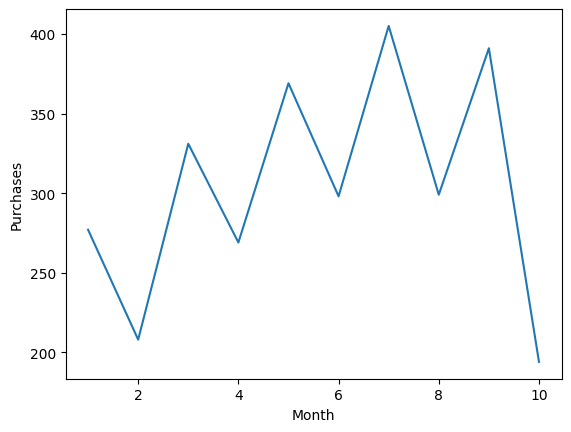

In [37]:
sns.lineplot(data=purchases_per_month, x='Month', y='Purchases')

In [11]:
student_engagement_df.head()

,engagement_id,student_id,engagement_quizzes,engagement_exams,engagement_lessons,date_engaged
0,1,274999,1,1,1,2022-05-27
1,3,274501,0,0,1,2022-05-27
2,4,272842,1,1,1,2022-05-27
3,8,275173,0,0,1,2022-05-27
4,11,274876,0,1,0,2022-05-27


In [12]:
student_purchases_df.head()

,purchase_id,student_id,purchase_type,date_purchased
0,15781,258800,Annual,2022-01-01
1,15786,258803,Annual,2022-01-01
2,15808,258862,Annual,2022-01-01
3,15809,258865,Annual,2022-01-01
4,15811,258878,Annual,2022-01-01


In [13]:
student_engagement_df[(student_engagement_df.student_id == 258800)]

,engagement_id,student_id,engagement_quizzes,engagement_exams,engagement_lessons,date_engaged
35,110905,258800,1,0,1,2022-01-03
36,110906,258800,1,0,1,2022-01-04
37,110907,258800,1,1,1,2022-01-05
38,110908,258800,1,1,1,2022-01-06
39,110909,258800,1,0,1,2022-01-10
40,110910,258800,1,0,1,2022-01-15
41,110911,258800,1,1,1,2022-01-23
42,110912,258800,1,0,1,2022-02-25
43,110913,258800,1,0,1,2022-02-26
44,110914,258800,1,0,1,2022-02-27
